## Machine Learning : Theory and Applications (2025/26)


#### Bibliography:
[1] Cocco et al., *From Statistical Physics to Data-Driven Modelling: with Applications to Quantitative Biology*, Oxford University Press (2022)


# ML for Neuroscience — Homework (START)

**Topic:** Independent and Gaussian models for neural population activity

**Goals**
- Build and preprocess spike-count matrices from neural recordings
- Fit an **independent Bernoulli model** to population activity during the task
- Evaluate the likelihood of neural configurations during **pre-** and **post-task** sleep
- Extend to a **Gaussian model** capturing pairwise correlations
- Compare inferred coupling (precision) matrices across behavioral states

**Note** / This notebook is builds on the *Tutorial 3: Principal Component Analysis (PCA) and replay of neural activity during sleep* of this course. See there for more details on the dataset and references.

## Context and experimental data (reminder)

We consider again the dataset introduced in **Tutorial 3**, which records **neural population activity** from the **prefrontal cortex (PFC)** of a rat across three behavioral epochs:

1. **Sleep 1 (pre-task sleep)** – baseline neural activity before the task
2. **Maze (task)** – neural activity during a spatial navigation task
3. **Sleep 2 (post-task sleep)** – neural activity after task completion

The data come from **multi-electrode recordings** capturing the spiking activity of multiple neurons across these behavioral states. The central question is whether **task-related neural patterns** are **reactivated during post-task sleep**, a hallmark of **replay** and **memory consolidation** within the two-stage model of learning.

We denote by $X_{\text{pre}}$, $X_{\text{task}}$, and $X_{\text{post}}$, the spike times are expressed in seconds, starting from $t = 0$, as obtained in Tutorial 3.


## Context and experimental data (reminder)

We consider again the dataset introduced in **Tutorial 3**, which records **neural population activity** from the **prefrontal cortex (PFC)** of a rat across three behavioral epochs:

1. **Sleep 1 (pre-task sleep)** – baseline neural activity before the task
2. **Maze (task)** – neural activity during a spatial navigation task
3. **Sleep 2 (post-task sleep)** – neural activity after task completion

The data come from **multi-electrode recordings** capturing the spiking activity of multiple neurons across these behavioral states. The central question is whether **task-related neural patterns** are **reactivated during post-task sleep**, a hallmark of **replay** and **memory consolidation** within the two-stage model of learning.

We denote by $X_{\text{pre}}$, $X_{\text{task}}$, and $X_{\text{post}}$, the spike times are expressed in seconds, starting from $t = 0$, as obtained in Tutorial 3.


## 2 - Independent-site model

In this section, we introduce a simple **independent model** of neural population activity, where each neuron is represented as a binary random variable that can either fire ($\sigma_{b,i}=1$) or remain silent ($\sigma_{b,i}=0$) in each time bin, **independently** of all others
(*cf.* Section 5.2.1 in [1]).

This model neglects correlations between neurons but provides a useful **baseline**: it captures overall firing propensities and allows us to test whether population activity during **pre-task** and **post-task sleep** becomes more or less compatible with the statistics learned during the **task**.

Let $\boldsymbol{\sigma}_{b,\bullet} = (\sigma_{b,1}, \dots, \sigma_{b,L})$ denote the **population activity vector** at time bin $b$. The model assumes that for all $b$, the joint probability factorizes as

$$
P^{\text{ind}}(\boldsymbol{\sigma}_{b,\bullet})
= \prod_{i=1}^L P_i(\sigma_{b,i})
\quad \text{with} \quad
P_i(\sigma_{b,i}) = \frac{e^{h_i \sigma_{b,i}}}{1 + e^{h_i}}.
$$

The MLE estimates of the parameters $h_i$ can be obtained by the moment-matching condition:
$$
\langle \sigma_i \rangle_{\text{data}} = \frac{e^{h_i}}{1 + e^{h_i}}\ ,
$$
where $\langle \sigma_i \rangle_{\text{data}}$ are the empirical mean activities of each neuron $i$:
$$
\langle \sigma_i \rangle_{\text{data}} = \frac{1}{M} \sum_{b=1}^M \sigma_{b,i}
$$


## 1 - From spikes to binary activity

#### 🎯 Question 1a. Discretization

- For each condition (`pre`, `task`, and `post`), and using time bins of width $\Delta t = 0.05\,\mathrm{s}$ (50 ms), construct the spike-count matrices $ S \in \mathbb{N}^{M \times L}, $
where each **row** corresponds to a time bin and each **column** to a neuron. Each entry $S_{b,i}$ represents the **number of spikes** emitted by neuron $i$ within time bin $b$.

#### 🎯 Question 1b. Binarisation
Then,  for each condition, **binarize** the data to obtain
$$
\sigma_{b,i} =
\begin{cases}
1 & \text{if}\ S_{b,i} >0 \\
0 & \text{otherwise.}
\end{cases}\ .
$$
Note that the binarized activity matrix $\boldsymbol{\sigma} \in \{0,1\}^{M \times L}$ has the same dimensions as $S$.

We will use the symbol $\boldsymbol{\sigma}_{\bullet,i} \in \{0,1\}^M$ to denote the activity of neuron $i$ across all $M$ time bins, i.e. the $i$-th column of $A$. Similarly, $\boldsymbol{\sigma}_{b,\bullet} \in \{0,1\}^L$ denote the population activity configuration in time bin $b$, i.e. the $b$-th row of $A$.


In [ ]:
import os
import numpy as np

# The code below is taken from tutorial 3, and the code is the result of discussion and collaboration with Eva Barraud, Rose Bourges, Eva, Bohan Chang, Jiayi Wu



##--- Load neural population activity ---
# Format: two columns
#   1st column → spike time (1 unit corresponds to 0.1 ms)
#   2nd column → neuron index (integer label)

X_pre  = np.loadtxt("/Users/giovannafurlan/Desktop/homework/Dati_181014_sleep1.txt")
X_task = np.loadtxt("/Users/giovannafurlan/Desktop/homework/Dati_181014_maze.txt")
X_post = np.loadtxt("/Users/giovannafurlan/Desktop/homework/Dati_181014_sleep2.txt")

# --- Sanity check ---
print("✅ Data successfully loaded. Shapes:")
print(f"  Pre-task sleep : {X_pre.shape}   (rows = spikes)")
print(f"  Task (maze)    : {X_task.shape}")
print(f"  Post-task sleep: {X_post.shape}")
def refine_spike_times(data):
    """Convert spike times from 0.1 ms to seconds and shift to start at 0."""
    data = data.copy()
    # Ensure float type for time manipulation
    data = data.astype(float)
    # Shift and scale
    data[:, 0] = (data[:, 0] - data[:, 0].min()) * 1e-4  
    return data

X_pre  = refine_spike_times(X_pre)
X_task = refine_spike_times(X_task)
X_post = refine_spike_times(X_post)
# --- Sanity check ---
print("\n ✅ Spike times converted to seconds and shifted to start at 0")
print(f"  Pre-task sleep : {X_pre[:,0].min():.1f} - {X_pre[:,0].max():.1f} s")
print(f"  Task (maze)     : {X_task[:,0].min():.1f} - {X_task[:,0].max():.1f} s")
print(f"  Post-task sleep: {X_post[:,0].min():.1f} - {X_post[:,0].max():.1f} s")

import matplotlib.pyplot as plt

def plot_spike_raster(session_data, t_range=(0,10), title=None):
    """
    Plot spike raster for a single session using vertical lines (vlines).

    Parameters
    ----------
    session_data : np.ndarray
        Array of shape (n_spikes, 2) with columns [time (s), neuron_id].
    t_range : tuple of float, optional
        (min_time, max_time) in seconds to display. Default is (0, 10).
    title : str or None, optional
        Plot title (e.g. 'Task (maze)'). If None, no title is displayed.
    """

    t_min, t_max = t_range

    # Select spikes within the specified time window
    mask = (session_data[:, 0] >= t_min) & (session_data[:, 0] <= t_max)
    times = session_data[mask, 0]
    neurons = session_data[mask, 1]
def discretize_data(data, dt=0.05, verbose=False):
    """
    Discretize spike events into an M×L spike-count matrix.

    Parameters
    ----------
    data : array-like, shape (n_spikes, 2)
        Columns: [time_sec, neuron_id]. Time is in seconds, already shifted to start at 0.
    dt : float
        Bin width in seconds (default: 0.05 s).
    verbose : bool
        If True, print additional information.
    Returns
    -------
    S : np.ndarray, shape (M, L)
        Spike-count matrix. Rows = time bins, columns = neurons (1..L mapped to 0..L-1).
    """
    times = data[:, 0] # First column: spike times (in seconds)
    ids   = data[:, 1].astype(int)  # Second column: neuron IDs (assumed to be 1..L)

    t_max = times.max()
    M = int(np.floor(t_max / dt)) + 1       # number of time bins
    L = int(ids.max())                      # assume IDs are 1..L

    S = np.zeros((M, L), dtype=int)

    # Bin index for each spike
    b = np.floor(times / dt).astype(int)
    # Column index for each spike (0-based)
    c = ids - 1

    # Accumulate counts
    np.add.at(S, (b, c), 1)

    if verbose:
        print(f"Data discretized into {M} time bins and {L} neurons.")
        print(f"Spike-count matrix shape: {S.shape} (M × L)")
    return S

dt = 0.05 # Bin width in seconds (50 ms)
S_pre  = discretize_data(X_pre,  dt=dt, verbose=True)
S_task = discretize_data(X_task, dt=dt, verbose=True)
S_post = discretize_data(X_post, dt=dt, verbose=True)

✅ Data successfully loaded. Shapes:
  Pre-task sleep : (317843, 2)   (rows = spikes)
  Task (maze)    : (304080, 2)
  Post-task sleep: (298054, 2)

 ✅ Spike times converted to seconds and shifted to start at 0
  Pre-task sleep : 0.0 - 1769.7 s
  Task (maze)     : 0.0 - 1408.5 s
  Post-task sleep: 0.0 - 1642.8 s
Data discretized into 35395 time bins and 37 neurons.
Spike-count matrix shape: (35395, 37) (M × L)
Data discretized into 28171 time bins and 37 neurons.
Spike-count matrix shape: (28171, 37) (M × L)
Data discretized into 32857 time bins and 37 neurons.
Spike-count matrix shape: (32857, 37) (M × L)


In [ ]:
import numpy as np

def binarize_spike_counts(S, verbose=False):
    """
    Binarize spike-count matrix S.
    
    Parameters
    ----------
    S : np.ndarray, shape (M, L)
        Spike-count matrix where:
        - M = number of time bins (rows)
        - L = number of neurons (columns)
        Each entry S[b,i] = number of spikes from neuron i in time bin b
    
    verbose : bool, optional
        If True, print summary statistics
    
    Returns
    -------
    sigma : np.ndarray, shape (M, L)
        Binarized activity matrix where:
        sigma[b,i] = 1 if S[b,i] > 0
        sigma[b,i] = 0 otherwise
    """
    # Binarize: 1 if any spikes occurred, 0 otherwise
    sigma = (S > 0).astype(int)
    
    if verbose:
        M, L = sigma.shape
        print(f"Binarized matrix shape: {sigma.shape} (M={M} bins × L={L} neurons)")
        print(f"Fraction of active bins: {sigma.mean():.4f}")
        print(f"Total active entries: {sigma.sum()} / {sigma.size}")
    
    return sigma


print("Pre-task sleep")
sigma_pre = binarize_spike_counts(S_pre, verbose=True)

print("Task")
sigma_task = binarize_spike_counts(S_task, verbose=True)

print("Post-task sleep")
sigma_post = binarize_spike_counts(S_post, verbose=True)

Pre-task sleep
Binarized matrix shape: (35395, 37) (M=35395 bins × L=37 neurons)
Fraction of active bins: 0.1794
Total active entries: 234951 / 1309615
Task
Binarized matrix shape: (28171, 37) (M=28171 bins × L=37 neurons)
Fraction of active bins: 0.2076
Total active entries: 216411 / 1042327
Post-task sleep
Binarized matrix shape: (32857, 37) (M=32857 bins × L=37 neurons)
Fraction of active bins: 0.1783
Total active entries: 216705 / 1215709


#### 🎯 Question 2a. Fitting the model

Starting grom the binarized data matrices from (1.b), estimate the empirical mean activities $\langle \sigma_i \rangle_{\text{data}}$ for each neuron $i$ from the **task** session, and use the moment-matching condition to derive the corresponding fields $h_i$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

"""
For an independent model, each neuron fires independently with probability p_i.
The model is:
    P(σ) = ∏_i p_i^σ_i (1-p_i)^(1-σ_i)

This can be written in exponential form:
    P(σ) = exp(∑_i h_i σ_i) / Z

where the field h_i relates to the firing probability via:
    p_i = <σ_i> = exp(h_i) / (1 + exp(h_i)) = sigmoid(h_i)

Or equivalently (moment-matching):
    h_i = log(p_i / (1 - p_i)) = logit(p_i)
"""

def fit_independent_model(sigma_task, verbose=True):
    """
    Fit independent model by estimating empirical mean activities.
    
    Parameters
    ----------
    sigma_task : np.ndarray, shape (M, L)
        Binarized activity matrix from task session
        M = number of time bins
        L = number of neurons
    
    verbose : bool
        If True, print detailed statistics
    
    Returns
    -------
    fire_rate : np.ndarray, shape (L,)
        Empirical mean activity <σ_i> for each neuron i
    h_fields : np.ndarray, shape (L,)
        Corresponding fields h_i from moment-matching
    f_clipped
    """
    M, L = sigma_task.shape
    
    # Compute empirical mean activity for each neuron
    fire_rate = sigma_task.mean(axis=0)  # Shape: (L,)
    
    # Compute fields using moment-matching: h_i = log(p_i / (1 - p_i)) 
    #to avoid log0
    eps = 1e-10
    f_clipped = np.clip(fire_rate, eps, 1 - eps)
    
    h_fields = np.log(f_clipped / (1 - f_clipped))
    
    return fire_rate, h_fields,f_clipped

# Fit the independent model on task data
fire_rate, h_fields, f_clipped= fit_independent_model(sigma_task, verbose=True)
print(fire_rate, h_fields, f_clipped)

[0.06201413 0.01210465 0.01324057 0.09967697 0.02513223 0.04359093
 0.11905861 0.33495439 0.04270349 0.0383373  0.18565191 0.01852969
 0.10106138 0.64878776 0.0368109  0.18895318 0.22356324 0.32071989
 0.06630933 0.38103014 0.30417806 0.05019346 0.4978169  0.7886834
 0.28131767 0.07990487 0.09481382 0.79411451 0.30726634 0.00653154
 0.00401122 0.16431792 0.11678677 0.01767775 0.43527031 0.16154911
 0.61538462] [-2.71637266 -4.40198738 -4.31114094 -2.20081893 -3.65815083 -3.08833669
 -2.00137524 -0.68586127 -3.10983254 -3.22224053 -1.47851442 -3.96967725
 -2.18548675  0.61371493 -3.26445562 -1.45682653 -1.24502088 -0.75046545
 -2.64481466 -0.48517811 -0.82748056 -2.94037355 -0.00873244  1.31700748
 -0.93793492 -2.44364031 -2.25622552  1.34990756 -0.81293068 -5.02455964
 -5.51464126 -1.6264452  -2.0232169  -4.01761241 -0.26037994 -1.64674682
  0.47000363] [0.06201413 0.01210465 0.01324057 0.09967697 0.02513223 0.04359093
 0.11905861 0.33495439 0.04270349 0.0383373  0.18565191 0.01852969


#### 🎯 Question 2b. Scoring configurations with the task model

Using the independent model fitted on the **task** data, the **log-probability** of each population activity configuration $\boldsymbol{\sigma}_{b,\bullet}$ reads:
$$
\log P^{\text{ind}}(\boldsymbol{\sigma}_{b,\bullet}) = \sum_{i=1}^{L} \left[ \sigma_{b,i} \log p_i + (1 - \sigma_{b,i})\log(1 - p_i) \right],
$$
where $p_i = \frac{e^{h_i}}{1 + e^{h_i}}$ are the firing probabilities from the task session.

**2.b.i** / Compute the log-probability for each time bin $b$ in the **pre-task**, **task**, and **post-task** sessions. Report the **mean and standard deviation** of log-probabilities for each session.
**2.b.ii** / Plot and compare the **distributions** of log-probability scores (one for each time bin) across the three sessions.
**2.b.iii** / Interpretation: What does the comparison of these distributions tell you about the similarity of population activity patterns before, during, and after the task? Which session's activity is best captured by the task model?

mean sleep1 and standard deviation -13.47790880923619 3.196255968479072 mean task and standard deviation -13.677238661062699 3.4069883103376286 mean sleep2 and standard deviation -13.677784429628014 3.3216758895256024


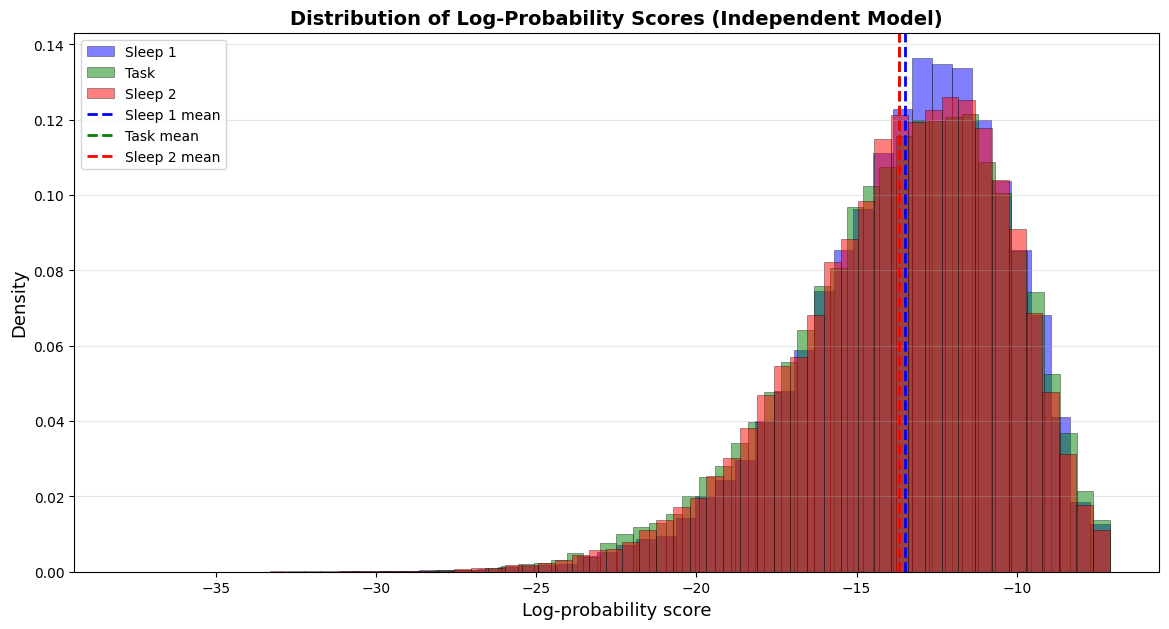

Intrestingly, the model is more likely to explain the pre-task sleep instead of the task itself, on which it has been fitted. The pre-task sleep mean is higher and thus the model does not provide evidence for memory replay or consolidation. The difference in performance might be due to the different state of neural activity the model could capture between the sleep1 (pre task) and the task itself. Since the model is built to capture the probability of neuronal firing, we can say that the task does not necessarily change the neuron firing rates


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

log_p_task= np.log(f_clipped)
log_1_minus_P = np.log(1-f_clipped)
def compute_independent_scores(sigma, log_p, log_1_minus_p):
    """
    Compute log-probability scores for each time bin under independent model.
    """
    # For each time bin b, compute: ∑_i h_i σ_b,i
    scores = sigma @ log_p_task + (1-sigma) @ log_1_minus_p   
    
    return scores




scores_sleep1 = compute_independent_scores(sigma_pre, log_p_task, log_1_minus_P)
scores_task = compute_independent_scores(sigma_task, log_p_task, log_1_minus_P)
scores_sleep2 = compute_independent_scores(sigma_post, log_p_task, log_1_minus_P)
    
mean_sleep1= np.mean(scores_sleep1)
std_sleep1= np.std(scores_sleep1)
mean_task= np.mean(scores_task)
std_task= np.std(scores_task)
mean_sleep2= np.mean(scores_sleep2)
std_sleep2= np.std(scores_sleep2)
print("mean sleep1 and standard deviation", mean_sleep1, std_sleep1, 
      "mean task and standard deviation", mean_task, std_task, 
       "mean sleep2 and standard deviation", mean_sleep2, std_sleep2)

def visualize_scores(results):
    """
    Create visualizations comparing score distributions across sessions.
    """
    sessions = results['sessions']
    
    # Use 1 plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 7)) 

    colors = ['blue', 'green', 'red']
    
    for (name, scores), color in zip(sessions.items(), colors):
        ax.hist(scores, bins=50, alpha=0.5, label=name, color=color, 
                density=True, edgecolor='black', linewidth=0.5)
    
    # Add vertical lines for means
    for (name, scores), color in zip(sessions.items(), colors):
        mean_score = np.mean(scores)
        ax.axvline(mean_score, color=color, linestyle='--', linewidth=2,
                   label=f'{name} mean')
    
    ax.set_xlabel('Log-probability score', fontsize=13)
    ax.set_ylabel('Density', fontsize=13)
    ax.set_title('Distribution of Log-Probability Scores (Independent Model)', 
                 fontsize=14, fontweight='bold')
    
    # This fix prevents duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=10, loc='upper left')

    ax.grid(True, alpha=0.3, axis='y')
    plt.show() # This is what makes the plot appear


results_to_plot = {
    'sessions': {
        'Sleep 1': scores_sleep1,
        'Task': scores_task,
        'Sleep 2': scores_sleep2
    }
}

visualize_scores(results_to_plot)
def visualize_scores(results):
    """
    Create visualizations comparing score distributions across sessions.
    
    2b.iii requirements:
    - Histograms of scores for all three sessions
    - Scores as a function of time bin for each session
    """
    sessions = results['sessions']
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))

    colors = ['blue', 'green', 'red']
    
    for (name, scores), color in zip(sessions.items(), colors):
        ax.hist(scores, bins=50, alpha=0.5, label=name, color=color, 
                density=True, edgecolor='black', linewidth=0.5)
    
    # Add vertical lines for means
    for (name, scores), color in zip(sessions.items(), colors):
        mean_score = np.mean(scores)
        ax.axvline(mean_score, color=color, linestyle='--', linewidth=2,
                   label=f'{name} mean')
    
    ax.set_xlabel('Log-probability score', fontsize=13)
    ax.set_ylabel('Density', fontsize=13)
    ax.set_title('Distribution of Log-Probability Scores (Independent Model)', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    plt.show()

print("Intrestingly, the model is more likely to explain the pre-task sleep instead of the task itself, on which it has been fitted. The pre-task sleep mean is higher and thus the model does not provide evidence for memory replay or consolidation. The difference in performance might be due to the different state of neural activity the model could capture between the sleep1 (pre task) and the task itself. Since the model is built to capture the probability of neuronal firing, we can say that the task does not necessarily change the neuron firing rates")



#### 🎯 Question 2c. Comparing neural representations across behavioral states

In Question 2b, you evaluated how well the **task model** scores configurations from different sessions. Now, we ask a complementary question: how do the **learned parameters** (the fields $h_i$) themselves differ across behavioral states?

**2.c.i** / Fit independent models separately on the **pre-task** and **post-task** data to obtain field vectors $\mathbf{h}_{\text{pre}}$ and $\mathbf{h}_{\text{post}}$.

**2.c.ii** /   Calculate and report the **cosine similarity** for the following pairs of local field vectors: $(\mathbf{h}_{\text{pre}}, \mathbf{h}_{\text{task}})$, $(\mathbf{h}_{\text{post}}, \mathbf{h}_{\text{task}})$,  $(\mathbf{h}_{\text{post}}, \mathbf{h}_{\text{pre}})$.

ℹ️ **Reminder**: The cosine similarity measures the alignment between two vectors, ranging from $-1$ (opposite directions) to $+1$ (same direction), and is defined as:
  $$
  \text{cosine similarity}(v_1, v_2) = \frac{v_1 \cdot v_2}{\|v_1\| \, \|v_2\|}
  $$
  where $v_1 \cdot v_2 $ is the dot product and $\|v\| $ is the Euclidean norm.



**2.c.iii** / Interpretation: Does the neural representation during post-task sleep resemble the task representation more closely than pre-task sleep does? How do these findings compare with those from Question 2b?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fit_single_session(sigma):
    """Fit model on a single session"""
    M, L = sigma.shape   
    fire_rate = sigma.mean(axis=0)    
    eps = 1e-10
    p_clipped = np.clip(fire_rate, eps, 1 - eps)
    h_fields = np.log(p_clipped / (1 - p_clipped))
    return h_fields
    
# Fit all three sessions
h_pre= fit_single_session(sigma_pre)
h_post= fit_single_session(sigma_post)
    
print(h_pre, h_post)

[-4.76877745 -4.16738274 -3.77326685 -2.3162422  -3.68448689 -3.53894078
 -2.65168856 -1.14260682 -4.2847759  -4.83881951 -1.96264354 -4.11423908
 -2.48239954  0.16224222 -4.26391259 -1.75564036 -1.91258702 -0.52521154
 -2.35131337 -1.5102533  -1.66142679 -2.81314122 -0.53720759  0.51602749
 -1.18640177 -5.15536808 -2.36671167  1.07848455 -1.51655806 -3.62138646
 -4.35228309 -1.94162266 -1.05048152 -4.82800052 -0.84118393  0.08645018
  0.92932056] [-4.44280523 -4.67028231 -3.78300749 -2.29964254 -3.76360085 -3.59051757
 -2.43639076 -1.02845495 -3.82876579 -4.63132361 -1.94956735 -4.11655032
 -2.32375866  0.2814178  -3.8273051  -1.82543317 -1.83437433 -0.30542318
 -3.49691528 -1.77639818 -1.70449633 -2.22932022 -0.89531458  0.80848051
 -1.2990635  -3.83316016 -2.17533482  1.08393557 -1.38637045 -2.72088031
 -4.60926672 -2.22170974 -0.94641898 -4.52551803 -1.35546006  0.02526232
  0.62934958]


In [ ]:
def compute_cosine_similarity(v1, v2):
    """
    Compute cosine similarity between two vectors.
    
    """
    dot_product = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    
    return dot_product / (norm1 * norm2)


sim_sleep1 = compute_cosine_similarity(h_pre, h_fields)
sim_sleep2 = compute_cosine_similarity(h_post, h_fields)
sim_sleep1_sleep2 = compute_cosine_similarity(h_pre, h_post)

print("--- Cosine Similarity of h-fields ---")
print(f"Sim(pre, task):  {sim_sleep1:.4f}")
print(f"Sim(post, task): {sim_sleep2:.4f}")
print(f"Sim(pre, post):  {sim_sleep1_sleep2:.4f}")
  


print("interpretation: thee cosine similarity is higher between sleep2 (post-task) and the task, compared to sleep1 and the task, therefore the post-task sleep vector resembled that of the task more closely. The log probability showed that, under the task model, sleep1 configuration were more probable than the sleep2 configurations, which suggested an absence of replay. The cosine similarity suggested that the model parameter were more similar in sleep 2 than sleep 1, which seem to support the hypothesis of replay. Question 2b indicated an opposite trend by considering the average of activity patterns, while this question was evaluating the parameters of the model") 

--- Cosine Similarity of h-fields ---
Sim(pre, task):  0.9493
Sim(post, task): 0.9518
Sim(pre, post):  0.9902
interpretation: thee cosine similarity is higher between sleep2 (post-task) and the task, compared to sleep1 and the task, therefore the post-task sleep vector resembled that of the task more closely. The log probability showed that, under the task model, sleep1 configuration were more probable than the sleep2 configurations, which suggested an absence of replay. The cosine similarity suggested that the model parameter were more similar in sleep 2 than sleep 1, which seem to support the hypothesis of replay. Question 2b indicated an opposite trend by considering the average of activity patterns, while this question was evaluating the parameters of the model


## 3 - Gaussian model with pairwise correlations

The independent model captures individual firing propensities but ignores **pairwise correlations** between neurons. We now extend our analysis to a **Gaussian model** that accounts for these correlations, providing a richer description of population activity.  (*cf.* Section 5.1 in [1])

For z-scored neural activity $Y_{b,\bullet} = (Y_{b,1}, \dots, Y_{b,L})$ with zero mean and unit variance, the Gaussian model assumes:
$$
P^{\text{Gauss}}(Y_{b,\bullet}) = \frac{1}{(2\pi)^{L/2} |C|^{1/2}} \exp\left(-\frac{1}{2} Y_{b,\bullet}^T \, T \, Y_{b,\bullet}\right),
$$

where $T = C^{-1}$ is the **precision matrix** (the inverse of the covariance matrix $C$).

Because the data are z-scored (zero mean, unit variance), the model is fully characterized by the **off-diagonal elements** $T_{ij}$ ($i \neq j$), which encode **effective pairwise couplings** between neurons. The **maximum likelihood estimate (MLE)** of the precision matrix is obtained by inverting the empirical covariance matrix: $T = C^{-1}$. A large positive (negative) coupling $T_{ij}$ indicates that neurons $i$ and $j$ tend to be active together (in opposite patterns) more often than expected by chance.

#### 🎯 Question 3a. Data preprocessing and correlation structure

Starting from the **spike-count matrices** $S_{\text{pre}}$, $S_{\text{task}}$, and $S_{\text{post}}$ (not the binarized versions!), **z-score** each matrix to obtain standardized activity matrices $Y$ with zero mean and unit variance per neuron, and compute the **sample correlation matrices** for each session:
$$
C = \frac{1}{M} Y^T Y
$$

*Note: See Tutorial 3, Q1b-c for reference on z-scoring the spike-count matrices (not the binarized ones!) and correlation computation.*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



def zscore_spike_counts(S, verbose=False):
    """
    Z-score spike-count matrix S.
    (tutorial 3)
    For each neuron (column), subtract mean and divide by standard deviation
    across time bins (rows).
    """
    
    # Compute mean and std for each neuron (across time bins)
    mean = S.mean(axis=0)  
    stds = S.std(axis=0, ddof=1) #ddof=1 for normalization    
    std_safe = np.where(stds>0, stds, 1.0)
    Y = (S - mean) / std_safe
    
    return Y


def compute_correlation_matrix(Y, verbose=False):
    """
    Compute sample correlation matrix.
    tutorial 3
    """
    M = Y.shape[0]
    
    return (Y.T @ Y) / M

Y_pre= zscore_spike_counts(S_pre)
Y_task= zscore_spike_counts(S_task)
Y_post= zscore_spike_counts(S_post)

C_pre= compute_correlation_matrix(S_pre)
C_task= compute_correlation_matrix(S_task)
C_post= compute_correlation_matrix(S_post)

print(Y_task, C_task)



[[-0.23833274 -0.10274144  7.83182587 ... -0.74278026  1.9566347
   0.07786702]
 [-0.23833274 -0.10274144 -0.11223371 ... -0.74278026 -0.41873079
  -0.98081625]
 [ 2.91233437 -0.10274144 -0.11223371 ... -0.74278026 -0.41873079
   0.07786702]
 ...
 [-0.23833274 -0.10274144 -0.11223371 ... -0.74278026 -0.41873079
   0.07786702]
 [-0.23833274 -0.10274144 -0.11223371 ... -0.74278026 -0.41873079
   1.13655029]
 [-0.23833274 -0.10274144 -0.11223371 ... -0.74278026 -0.41873079
   0.07786702]] [[1.06456995e-01 4.61467467e-04 4.25969969e-04 ... 4.18870470e-02
  1.47669589e-02 9.08380959e-02]
 [4.61467467e-04 1.92041461e-02 4.96964964e-04 ... 7.41897696e-03
  2.34283483e-03 1.25661141e-02]
 [4.25969969e-04 4.96964964e-04 1.60448688e-02 ... 8.80337936e-03
  2.69780980e-03 1.18206666e-02]
 ...
 [4.18870470e-02 7.41897696e-03 8.80337936e-03 ... 9.67981257e-01
  9.64112030e-02 5.23446097e-01]
 [1.47669589e-02 2.34283483e-03 2.69780980e-03 ... 9.64112030e-02
  2.08299315e-01 1.66376770e-01]
 [9.08380


#### 🎯 Question 3b. Scoring configurations with the Gaussian model

**3.b.i** / Compute the **precision matrix** $T_{\text{task}} = C_{\text{task}}^{-1}$ from the task session.

**3.b.ii** / For each time bin $b$ in all three sessions, compute the log-probability under the Gaussian model fitted on the task:
  $$
  \log P^{\text{Gauss}}(Y_{b,\bullet}) = -\frac{1}{2} \sum_{i \neq j} T_{ij} Y_{b,i} Y_{b,j}
  $$
  **Note:** We exclude diagonal terms $T_{ii}$ since the z-scoring already accounts for individual firing rates. Furthermore, the normalization constant is omitted as it is the same for all configurations.

Report the **mean and standard deviation** of log-probability scores for each session.


**3.b.iii** / Create visualizations to compare the distributions.
- Plot histograms of log-probability scores for all three sessions (use logarithmic y-scale if needed).
- Plot log-probability scores as a function of time bin for each session.

**3.b.iv** / Intepretation: How do these results compare with those from the independent model (Question 2b)? Does accounting for correlations change which session's activity is best captured by the task model?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

T = np.linalg.inv(C_task)
print("the precision matrix is", T)

the precision matrix is [[ 1.05665183  0.01239437  0.013842   ...  0.02412577 -0.01380643
  -0.05543033]
 [ 0.01239437  1.00392228 -0.01617911 ...  0.01065111  0.0021486
   0.00288058]
 [ 0.013842   -0.01617911  1.00311016 ... -0.00385395 -0.00536754
   0.00839704]
 ...
 [ 0.02412577  0.01065111 -0.00385395 ...  1.02607906  0.02243802
   0.02968179]
 [-0.01380643  0.0021486  -0.00536754 ...  0.02243802  1.00382609
  -0.00607358]
 [-0.05543033  0.00288058  0.00839704 ...  0.02968179 -0.00607358
   1.01677527]]


In [ ]:
# Create T without diagonal (set diagonal to 0)
T_offdiag = T.copy()
np.fill_diagonal(T_offdiag, 0)

def compute_gaussian_log_probability(Y_ses,T_off):
    """
    Compute log-probability for each time bin under Gaussian model.

    """
    M, L = Y_ses.shape
    
    # For each time bin b, compute: -0.5 * Y_b^T * T_offdiag * Y_b
    # Vectorized: (Y @ T_offdiag) gives M×L matrix where each row is T_offdiag @ Y_b^T
    # Element-wise multiply with Y and sum across neurons
    log_probs = -0.5 * np.sum((Y_ses @ T_off) * Y_ses, axis=1)
    
    return log_probs
    
log_probs_sleep1 = compute_gaussian_log_probability(Y_pre, T_offdiag)
log_probs_task = compute_gaussian_log_probability(Y_task, T_offdiag)
log_probs_sleep2 = compute_gaussian_log_probability(Y_post, T_offdiag)

print("the mean and standard deviation of log probability scores for each sessions are respectfully", np.mean(log_probs_sleep1),np.std(log_probs_sleep1), np.mean(log_probs_task),np.std(log_probs_task), np.mean(log_probs_sleep2), np.std(log_probs_sleep2))

the mean and standard deviation of log probability scores for each sessions are respectfully 0.10414503074790873 0.7133518340673715 0.43720552488248066 1.0270408481529314 0.19863989791129286 1.2085531422023816


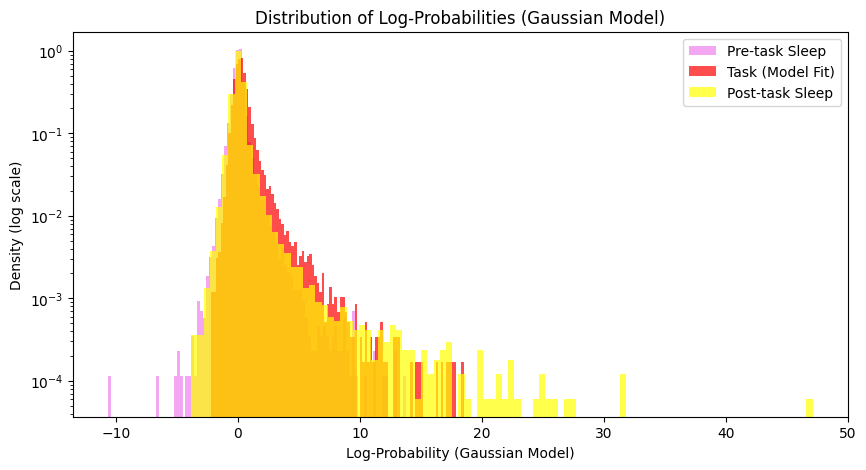

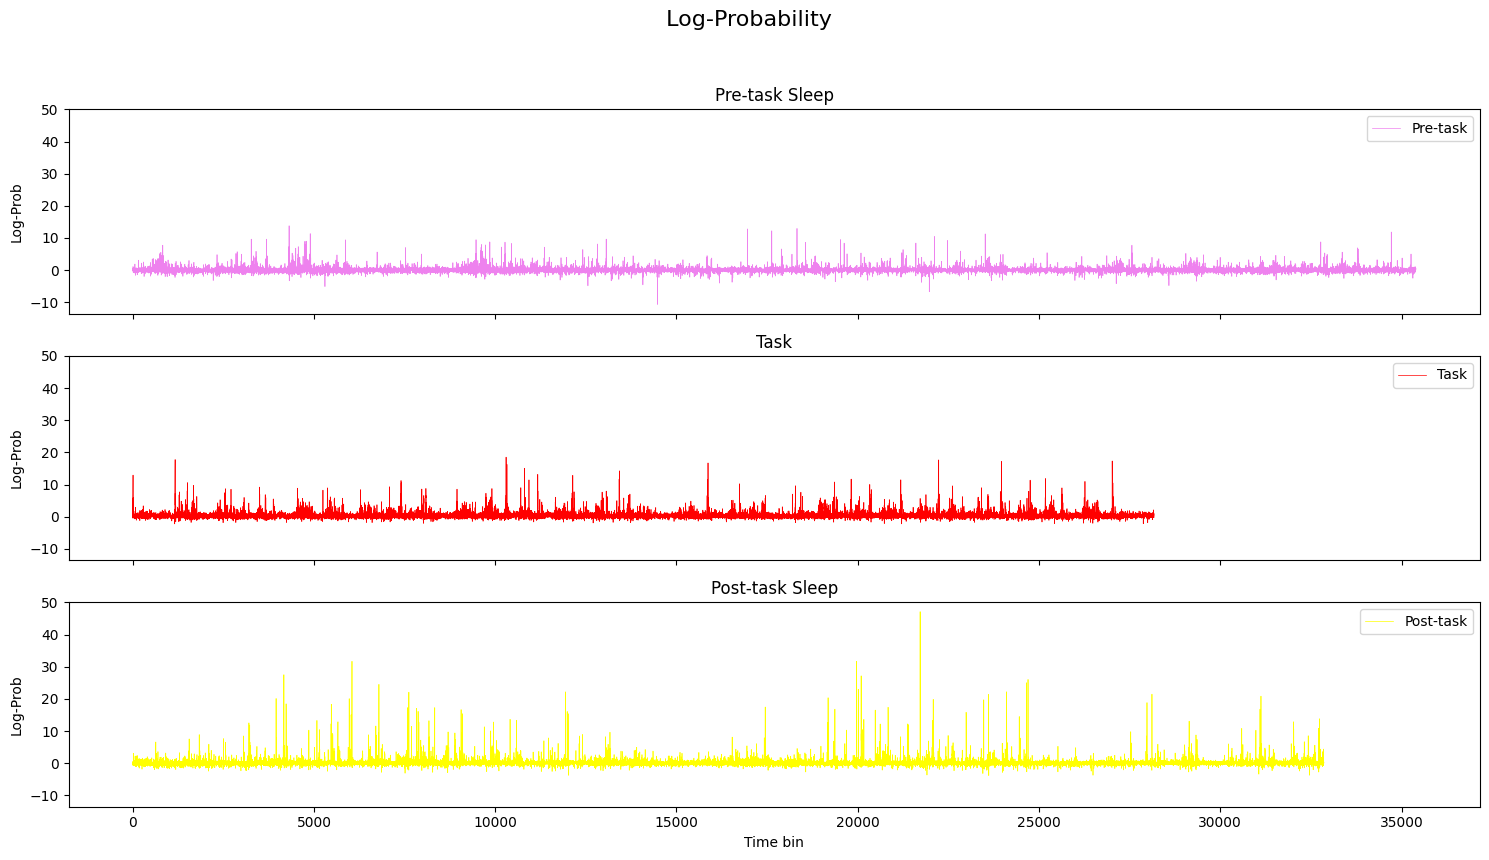

interpretation: the two results of the Gaussian model and the indipendent model clash. The indipendent model showed no evidence of replay, as it fits the pre task sleep data better, while the Gaussian model shows that post-task sleep scores are shifted towards higher scores compared to pre-task sleep. Furthermore, post-task sleep also contains evidence of replay (spikes) which are absent in pre-task sleep. Indeed, accounting for correlations by using Gaussian model accounts for the change in the result, since it manages to capture the activity of the post task sleep session


In [ ]:
plt.figure(figsize=(10, 5))

plt.hist(log_probs_sleep1, bins=100, density=True, alpha=0.7, label="Pre-task Sleep", log=True, color='violet')
plt.hist(log_probs_task, bins=100, density=True, alpha=0.7, label="Task (Model Fit)", log=True, color='red')
plt.hist(log_probs_sleep2, bins=100, density=True, alpha=0.7, label="Post-task Sleep", log=True, color='yellow')

plt.xlabel("Log-Probability (Gaussian Model)")
plt.ylabel("Density (log scale)")
plt.title("Distribution of Log-Probabilities (Gaussian Model)")
plt.legend()
plt.savefig('Distribution of Log-Probabilities (Gaussian Model).png')
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 9), sharex=True, sharey=True)

# 1. Pre-task sleep
time_pre = np.arange(len(log_probs_sleep1))
ax1.plot(time_pre, log_probs_sleep1, lw=0.5, label="Pre-task", color='violet') # <-- Changed color
ax1.set_title("Pre-task Sleep")
ax1.set_ylabel("Log-Prob")
ax1.legend()

# 2. Task
time_task = np.arange(len(log_probs_task))
ax2.plot(time_task, log_probs_task, lw=0.5, label="Task", color='red') # <-- Changed color
ax2.set_title("Task")
ax2.set_ylabel("Log-Prob")
ax2.legend()

# 3. Post-task sleep
time_post = np.arange(len(log_probs_sleep2))
ax3.plot(time_post, log_probs_sleep2, lw=0.5, label="Post-task", color='yellow') # <-- Changed color
ax3.set_title("Post-task Sleep")
ax3.set_ylabel("Log-Prob")
ax3.set_xlabel("Time bin")
ax3.legend()

plt.suptitle(" Log-Probability", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("interpretation: the two results of the Gaussian model and the indipendent model clash. The indipendent model showed no evidence of replay, as it fits the pre task sleep data better, while the Gaussian model shows that post-task sleep scores are shifted towards higher scores compared to pre-task sleep. Furthermore, post-task sleep also contains evidence of replay (spikes) which are absent in pre-task sleep. Indeed, accounting for correlations by using Gaussian model accounts for the change in the result, since it manages to capture the activity of the post task sleep session") 

#### 🎯 Question 3c. Comparing coupling matrices across behavioral states

The precision matrix $T$ (or equivalently, its negative $J = -T$, called the **coupling matrix**) encodes the interaction structure between neurons. We now ask: how does this interaction structure differ across behavioral states?

**3.c.i** / Compute the coupling matrices for all three sessions:
  $$
  J_{\text{pre}} = -C_{\text{pre}}^{-1}, \quad J_{\text{task}} = -C_{\text{task}}^{-1}, \quad J_{\text{post}} = -C_{\text{post}}^{-1}
  $$

**3.c.ii** / Visualize the three coupling matrices as heatmaps (with diagonal elements set to zero for clarity).

**3.c.iii** / Compute the **cosine similarity** (see definition above) between the linearised off-diagonal elements of each pair of coupling matrices: ($J_{\text{pre}}$ and $J_{\text{task}}$), ($J_{\text{post}}$ and $J_{\text{task}}$), and ($J_{\text{pre}}$ and $J_{\text{post}}$).

💡 *Hint*: You can extract and vectorize the off-diagonal elements by using the following helper function:

**3.c.iv** / Interpretation: Do the pairwise coupling patterns during post-task sleep resemble those during the task more than pre-task sleep does? What does this tell you about the consolidation of interaction structure between neurons during sleep?

In [ ]:
J_sleep1=-np.linalg.inv(C_pre)
J_task=-np.linalg.inv(C_task)
J_sleep2=-np.linalg.inv(C_post)

print("the coupling matrices for all three sessions are", J_sleep1, J_task, J_sleep2)

the coupling matrices for all three sessions are [[-1.00180189e+00 -2.68892064e-03 -6.96183165e-03 ... -5.27347335e-03
   2.90199098e-03  5.59368422e-03]
 [-2.68892064e-03 -1.00861706e+00 -4.93995675e-04 ...  2.63029456e-03
  -6.81547536e-04 -4.87286880e-05]
 [-6.96183165e-03 -4.93995675e-04 -1.00353045e+00 ...  4.28306879e-03
  -1.43582622e-02  1.67570547e-04]
 ...
 [-5.27347335e-03  2.63029456e-03  4.28306879e-03 ... -1.00491822e+00
  -6.04409305e-03 -1.25498195e-02]
 [ 2.90199098e-03 -6.81547536e-04 -1.43582622e-02 ... -6.04409305e-03
  -1.01245591e+00  1.49042371e-02]
 [ 5.59368422e-03 -4.87286880e-05  1.67570547e-04 ... -1.25498195e-02
   1.49042371e-02 -1.02102779e+00]] [[-1.05665183 -0.01239437 -0.013842   ... -0.02412577  0.01380643
   0.05543033]
 [-0.01239437 -1.00392228  0.01617911 ... -0.01065111 -0.0021486
  -0.00288058]
 [-0.013842    0.01617911 -1.00311016 ...  0.00385395  0.00536754
  -0.00839704]
 ...
 [-0.02412577 -0.01065111  0.00385395 ... -1.02607906 -0.02243802
  

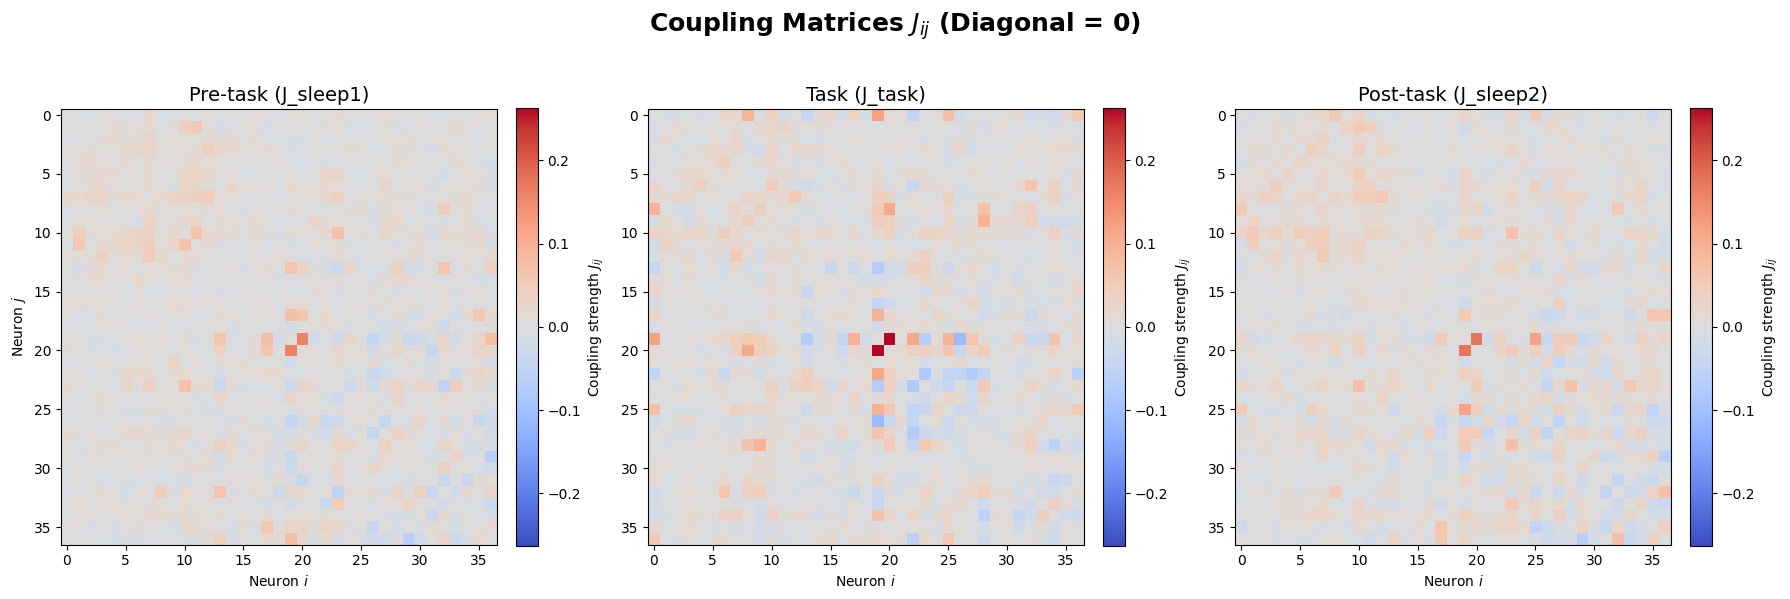

In [ ]:

def plot_coupling_matrices(J_pre, J_task, J_post, save_filename="coupling_matrices_heatmaps.png"):
    """
    Visualizes the three coupling matrices as heatmaps.
    The diagonal elements are set to zero for clarity.
    """
    
    matrices = {
        "Pre-task (J_sleep1)": J_pre.copy(),
        "Task (J_task)": J_task.copy(),
        "Post-task (J_sleep2)": J_post.copy()
    }
    
    # Set diagonals to zero for all matrices
    for J in matrices.values():
        np.fill_diagonal(J, 0)
        
    # Find the global min/max of off-diagonal elements for a consistent color scale
    all_vals = np.concatenate([J.flatten() for J in matrices.values()])
    v_abs = np.max(np.abs(all_vals[~np.isnan(all_vals)]))
    if v_abs == 0: v_abs = 1.0 # Avoid vmin=vmax=0
    vmin, vmax = -v_abs, v_abs

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for ax, (title, J) in zip(axes, matrices.items()):
        im = ax.imshow(J, cmap='coolwarm', vmin=vmin, vmax=vmax)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Neuron $i$")
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Coupling strength $J_{ij}$')
        
    axes[0].set_ylabel("Neuron $j$")
        
    plt.suptitle("Coupling Matrices $J_{ij}$ (Diagonal = 0)", fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')
    plt.show()


plot_coupling_matrices(J_sleep1, J_task, J_sleep2)

In [ ]:
# Helper function from homework_start
def offdiag_vec(J):
    """Vectorize the strictly upper-triangular (off-diagonal) entries of J."""
    iu = np.triu_indices_from(J, k=1)
    return J[iu]
    
# Vectorize off-diagonal elements
v_sleep1 = offdiag_vec(J_sleep1)
v_task = offdiag_vec(J_task)
v_sleep2 = offdiag_vec(J_sleep2)

# Calculate cosine similarities
sim_J_sleep1 = compute_cosine_similarity(v_sleep1, v_task)
sim_J_sleep2 = compute_cosine_similarity(v_sleep2, v_task)
sim_J_sleep1_sleep2 = compute_cosine_similarity(v_sleep1, v_sleep2)

print("--- Cosine Similarity of J-matrices (off-diagonal) ---")
print(f"Sim(J_sleep1, J_task):  {sim_J_sleep1:.4f}")
print(f"Sim(J_sleep2, J_task): {sim_J_sleep2:.4f}")
print(f"Sim(J_sleep1, J_sleep2):  {sim_J_sleep1_sleep2:.4f}")

print("interpretation: yes, the pairwise couplings of sleep2 are more similar to the task of those of sleep1. This result offer a partial supports for the hypothesis of memory consolidation, as the couplings of neurons that differed between sleep1 and sleep2 could have been altered by the task")

--- Cosine Similarity of J-matrices (off-diagonal) ---
Sim(J_sleep1, J_task):  0.3549
Sim(J_sleep2, J_task): 0.5570
Sim(J_sleep1, J_sleep2):  0.6059
interpretation: yes, the pairwise couplings of sleep2 are more similar to the task of those of sleep1. This result offer a partial supports for the hypothesis of memory consolidation, as the couplings of neuron differed between sleep1 and sleep2 was altered by the task
